In [1]:
import os
import iris
import xarray as xr
import xesmf as xe
import numpy as np
import matplotlib.pyplot as plt
import cmocean
from matplotlib import cm
os.chdir('/home/548/eh6215/python/BARPA_evaluation/emma/PBE')
import datasets

In [2]:
ia39path = "/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/output/AUS-15/BOM/{model}/{scen}/{rev}/BOM-BARPA-R/v1/{time}/{var}/{var}_AUS-15_{model}_{scen}_r1i1p1f1_BOM-BARPA-R_v1_{time}_{year}01-{year}12.nc"

In [3]:
barpa = xr.open_mfdataset(ia39path.format(time='mon',var='pr',scen='evaluation',year='*',model='ECMWF-ERA5',rev='r1i1p1f1'))
agcd = xr.open_mfdataset(["/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_%d.nc"%year for year in range(1979,2008)])
nrm = xr.open_dataset("/home/548/eh6215/NRM_clusters.nc")

In [4]:
order=np.array([(nrm.lat.where(nrm.ids==i).mean().values*1) for i in range(len(nrm.labels))]).argsort()
labels = nrm.labels.values[order]
print(labels)
labels[2] = "S&SW Flatlands"

['Southern Slopes' 'Murray Basin' 'Southern and South-Western Flatlands'
 'Central Slopes' 'East Coast' 'Rangelands' 'Monsoonal North'
 'Wet Tropics']


In [5]:
month_length = barpa.time.dt.days_in_month
barpa['pr'] = barpa['pr']*86400*month_length

In [6]:
def agg_regions(data,nrm,var,order):
    # regrid regions to data grid
    regridder = xe.Regridder(nrm, data, 'nearest_s2d')
    nrm_regrid = regridder(nrm.ids)
    regions = xr.concat(
                        [(nrm_regrid == region_id).expand_dims(region=[i])
                         for i, region_id in enumerate(order)], 
                          dim='region'
                       )
    result = data[var].where(regions).mean(['lat', 'lon'])
    result = result.load()  # now the data is small (8 timeseries), commit to memory
    return result


In [7]:
barpa_agg = agg_regions(barpa,nrm,'pr',order)
agcd_agg = agg_regions(agcd,nrm,'precip',order)

In [8]:
barpa_mm = barpa_agg.groupby('time.month').mean()
agcd_mm = agcd_agg.groupby('time.month').mean()

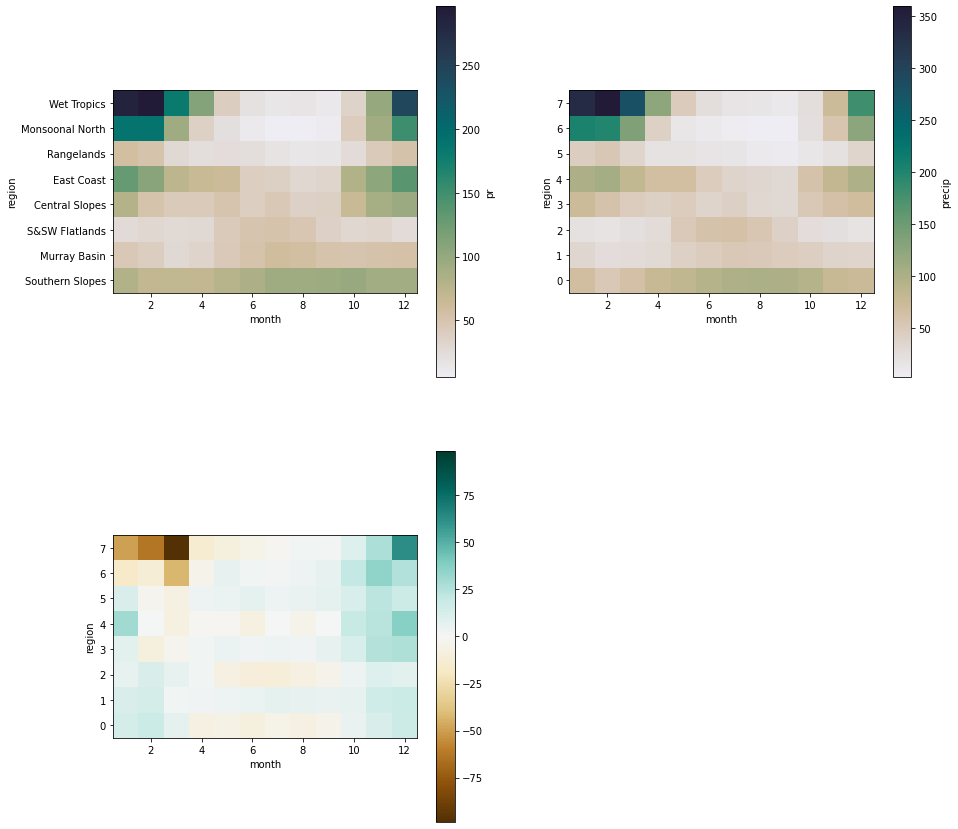

In [9]:
plt.figure(figsize=(15,15))
plt.subplot(221,aspect=1)
(barpa_mm).plot.pcolormesh(x='month',y='region',cmap=cmocean.cm.rain)
plt.yticks(range(8),labels)
plt.subplot(222,aspect=1)
(agcd_mm).plot.pcolormesh(x='month',y='region',cmap=cmocean.cm.rain)
plt.subplot(223,aspect=1)
(barpa_mm-agcd_mm).plot.pcolormesh(x='month',y='region',cmap='BrBG')


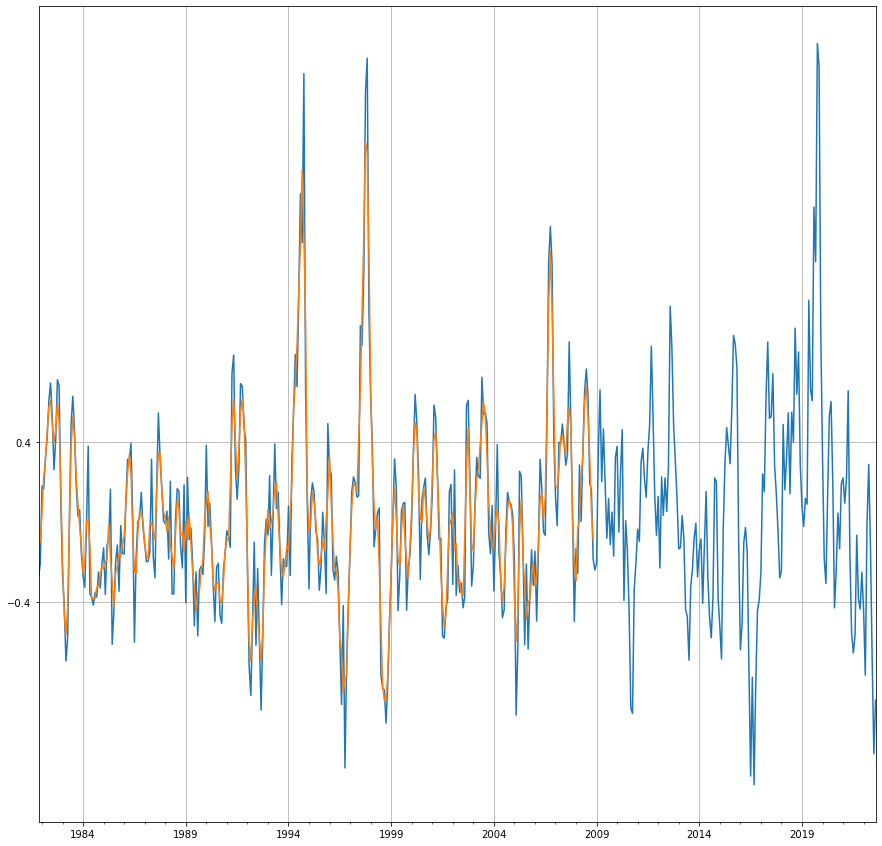

In [59]:
plt.figure(figsize=(15,15))
nino = datasets.nino()[:agcd.precip.shape[0]]
dmi = datasets.dmi()
dmi = dmi.resample('M').mean()
dmi.plot()
dmi=dmi.rolling(3,center=True).mean()
dmi=dmi[1:agcd.precip.shape[0]-23]
dmi.plot()
plt.yticks([-0.4,0.4])
plt.grid()


In [12]:
def composite(data,index,normed = False):
    weights = data[index].groupby('time.month').count()
    mm = data.groupby('time.month').mean()
    anom = data[index].groupby('time.month').mean() - mm
    output = (anom*weights).sum('month')/weights.sum('month')
    if normed:
        norm = (mm*weights).sum('month')/weights.sum('month')
        return output/norm
    return output

In [44]:
def annotate(pcolormesh,data,string):
    amp = (np.array(cm.get_cmap(x.cmap)(x.norm(data)))**2).mean(axis=2)
    print(amp.shape,data.shape)
    for i in range(data.shape[1]):
        for j in range(data.shape[0]):
            plt.text(i,j,string%data[j,i],color=['k','w'][int(amp[j,i]<0.4)],ha='center',va='center')
    cm.get_cmap('BrBG')(1)

(4, 8) (4, 8)


Text(0.5, 0, '')

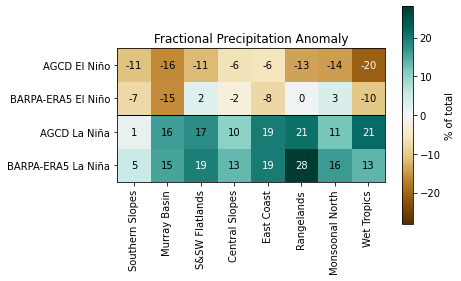

In [20]:
norm=True
pr_nino= xr.concat(
   [composite(barpa_agg,nino.values<-0.8,normed=norm).expand_dims(index=[0]),
    composite(agcd_agg,nino.values<-0.8,normed=norm).expand_dims(index=[1]),
    composite(barpa_agg,nino.values>0.8,normed=norm).expand_dims(index=[2]),
    composite(agcd_agg,nino.values>0.8,normed=norm).expand_dims(index=[3])],
    dim='index')
plt.subplot(111,aspect=1)
x=(100*pr_nino).plot.pcolormesh(cmap='BrBG',cbar_kwargs = {'label':"% of total"})
plt.xticks(range(8),labels,rotation=90)
plt.yticks(range(4),['BARPA-ERA5 La Niña','AGCD La Niña','BARPA-ERA5 El Niño','AGCD El Niño'])
plt.plot([-.5,7.5],[1.5,1.5],'k',lw=1)
annotate(x,100*pr_nino.values,"%d")
plt.title("Fractional Precipitation Anomaly")
plt.ylabel("")
plt.xlabel("")

(4, 8) (4, 8)


Text(0.5, 0, '')

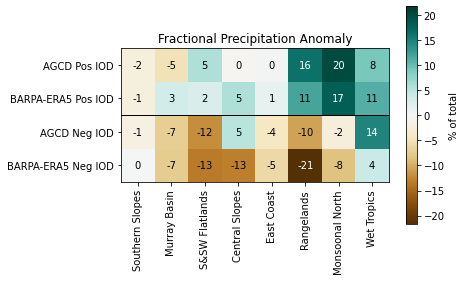

In [60]:
norm=True
pr_nino= xr.concat(
   [composite(barpa_agg[24:],dmi.values<-0.4,normed=norm).expand_dims(index=[0]),
    composite(agcd_agg[24:],dmi.values<-0.4,normed=norm).expand_dims(index=[1]),
    composite(barpa_agg[24:],dmi.values>0.4,normed=norm).expand_dims(index=[2]),
    composite(agcd_agg[24:],dmi.values>0.4,normed=norm).expand_dims(index=[3])],
    dim='index')
plt.subplot(111,aspect=1)
x=(100*pr_nino).plot.pcolormesh(cmap='BrBG',cbar_kwargs = {'label':"% of total"})
plt.xticks(range(8),labels,rotation=90)
plt.yticks(range(4),['BARPA-ERA5 Neg IOD','AGCD Neg IOD','BARPA-ERA5 Pos IOD','AGCD Pos IOD'])
plt.plot([-.5,7.5],[1.5,1.5],'k',lw=1)
annotate(x,100*pr_nino.values,"%d")
plt.title("Fractional Precipitation Anomaly")
plt.ylabel("")
plt.xlabel("")

#### barpa_agg.time[22:]

In [25]:
dmi

1981-11-04   -0.062497
1981-11-11   -0.278864
1981-11-18   -0.394537
1981-11-25   -0.369909
1981-12-02   -0.111285
                ...   
2022-08-03   -0.969909
2022-08-10   -0.889959
2022-08-17   -1.071432
2022-08-24   -0.908041
2022-08-31   -0.615687
Length: 2131, dtype: float64

1981-11-30   -0.276452
1981-12-31   -0.206340
1982-01-31    0.182273
1982-02-28    0.167764
1982-03-31    0.324189
                ...   
2022-04-30    0.290426
2022-05-31   -0.113026
2022-06-30   -0.682071
2022-07-31   -1.160309
2022-08-31   -0.891005
Freq: M, Length: 490, dtype: float64

In [197]:
dmi

<xarray.Dataset>
Dimensions:  (WEDCEN2: 2131)
Coordinates:
  * WEDCEN2  (WEDCEN2) datetime64[ns] 1981-11-04 1981-11-11 ... 2022-08-31
Data variables:
    DMI      (WEDCEN2) float64 -0.0625 -0.2789 -0.3945 ... -1.071 -0.908 -0.6157
Attributes:
    history:      FERRET V7.3 (optimized)  6-Sep-22
    Conventions:  CF-1.6

In [16]:
nino.values<-0.8

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False,

In [50]:
dmi

Rolling [window=5,center=False,axis=0,method=single]